# HSE 2025: Mathematical Methods for Data Analysis

## Seminar 8: Ensembles, RandomForest
**Author**: Maria Tikhonova


In [1]:
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.datasets import fetch_california_housing
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphviz
import pydotplus

from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")


# Increase viewable area of Pandas tables, numpy arrays, plots
np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)
sns.set()
plt.rcParams['figure.figsize'] = [16, 6]

# 1. Bias-Variance Decomposition

Consider regression task with MSE error metric. Suppose the following true relationship:

$$
y(x) = f(x) + \epsilon
$$

where $ \epsilon $ is gaussian white noise, $\epsilon \sim \mathcal{N}(0,\sigma^2) $. Denote the regression model predictions as $ a(x) = \hat{y} $. Then, for the error expected value we have:

\begin{equation}
\begin{split}
Error & = \mathbb{E}_{X,Y,\epsilon}\left[(a(x) - y(x))^2\right] = \\
      & = \mathbb{E}_{X,Y}\left[(a(x) - \mathbb{E}_{X,Y}[a(x)])^2\right]  + \left(\mathbb{E}_{X,Y}\left[a(x)\right] - f(x)\right)^2 +  \sigma^2 = \\ & = \text{Variance} + \text{Bias}^2  + \text{Noise}
\end{split}
\end{equation}

Those components can be interpreted as
* $\text{Variance}$ (Разброс) - model's sensivity to dataset. High variance usually means that model is overfitted.
* $\text{Bias}$ (Смещение) - is in charge of model's precision. High bias usually means that model is underfitted.
* $\text{Noise}$ (Шум) - that is just noise

## Example

Consider an example of a regression task with kNN regression model.

### One model

In [2]:
# Define target function for regression
def f(x):
    return np.sin(x)

Generate train and test samples

In [3]:
# Define noise level
sigma = 0.2

# Generate train sample
X_train = np.random.random(size=5) * 2 * np.pi
y_train = f(X_train) + np.random.normal(loc=0., scale=sigma, size=len(X_train))

# Generate test smaple
X_test = np.linspace(0, 2*np.pi, 1000)
y_test = f(X_test) + np.random.normal(loc=0., scale=sigma, size=len(X_test))

Fit a regression model

In [4]:
from sklearn.neighbors import KNeighborsRegressor

# Create a model
reg = KNeighborsRegressor(n_neighbors=1)

# Fit the model
reg.fit(X_train.reshape(-1, 1), y_train)

KNeighborsRegressor(n_neighbors=1)

Make prediction on test sample

In [5]:
from sklearn.metrics import mean_squared_error

# Make predictions
y_test_predict = reg.predict(X_test.reshape(-1, 1))

Plot predictions

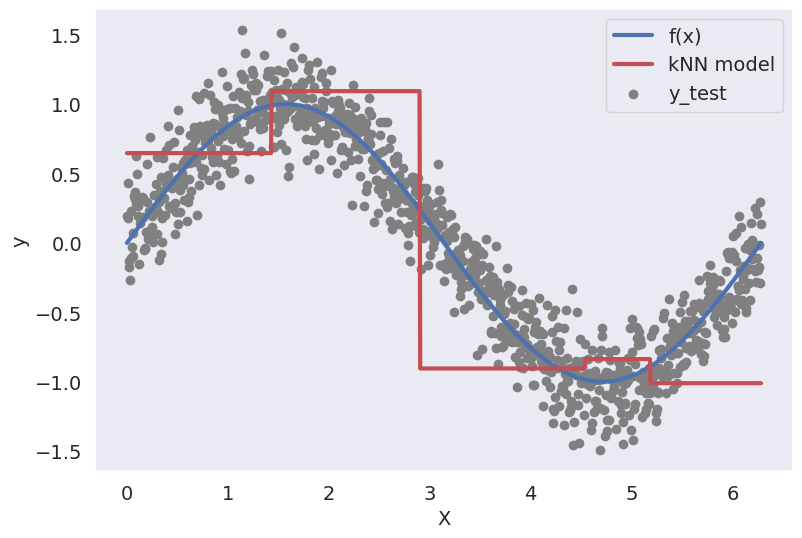

In [6]:
plt.figure(figsize=(9, 6))

plt.plot(X_test, f(X_test), label='f(x)', color='b', linewidth=3)
plt.plot(X_test, y_test_predict, label='kNN model', color='r', linewidth=3)
plt.scatter(X_test, y_test, label='y_test', color='0.5')

plt.xticks(size=14)
plt.xlabel("X", size=14)
plt.yticks(size=14)
plt.ylabel("y", size=14)
plt.legend(loc='best', fontsize=14)
plt.grid()
plt.show()

Plot prediction errors

In [7]:
errors = (y_test_predict - y_test)**2

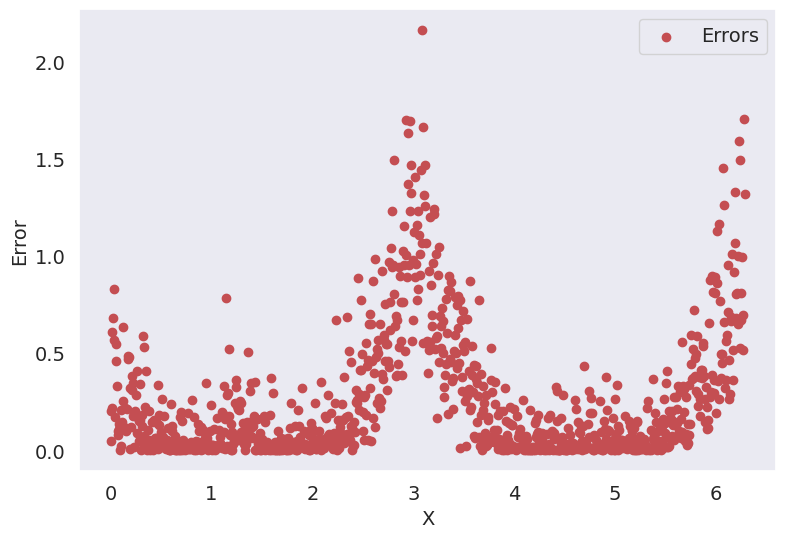

In [8]:
plt.figure(figsize=(9, 6))

plt.scatter(X_test, errors, label='Errors', color='r')

plt.xticks(size=14)
plt.xlabel("X", size=14)
plt.yticks(size=14)
plt.ylabel("Error", size=14)
plt.legend(loc='best', fontsize=14)
plt.grid()
plt.show()

## Several models

Train Several Models on Random Train Samples

In [9]:
# Define noise level
sigma = 0.2

# Generate train sample
X_train = np.random.random(size=5) * 2 * np.pi
y_train = f(X_train) + np.random.normal(loc=0., scale=sigma, size=len(X_train))

# Generate test smaple
X_test = np.linspace(0, 2*np.pi, 1000)
y_test = f(X_test) + np.random.normal(loc=0., scale=sigma, size=len(X_test))

In [10]:
N_iter = 1000
predictions = []
errors = []

for i in range(N_iter):

    # Generate random train sample
    X_train = np.random.random(size=5) * 2 * np.pi
    y_train = f(X_train) + np.random.normal(loc=0., scale=sigma, size=len(X_train))

    # Create a model
    reg = KNeighborsRegressor(n_neighbors=1)

    # Fit the model
    reg.fit(X_train.reshape(-1, 1), y_train)

    # Make predictions
    y_test_predict = reg.predict(X_test.reshape(-1, 1))

    # Save predictions
    predictions.append(y_test_predict)

    # Generate random test y
    y_test_iter = f(X_test) + np.random.normal(loc=0., scale=sigma, size=len(X_test))

    # Calculate errors
    errors_iter = (y_test_predict - y_test_iter)**2

    # Save errors
    errors.append(errors_iter)

predictions = np.array(predictions)
errors = np.array(errors)

Estimate expected model's predictions

In [11]:
y_test_predict_mean = predictions.mean(axis=0)

Plot models

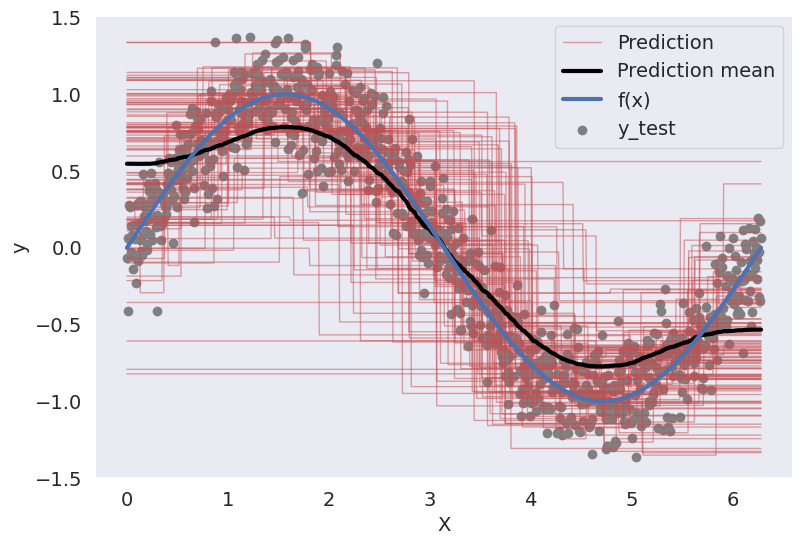

In [12]:
plt.figure(figsize=(9, 6))

for y_test_predict in predictions[:100]:
    plt.plot(X_test, y_test_predict, color='r', linewidth=1, alpha=0.5)

plt.plot(X_test, predictions[0], label='Prediction', color='r', linewidth=1, alpha=0.5)
plt.plot(X_test, y_test_predict_mean, label='Prediction mean', color='0', linewidth=3)
plt.plot(X_test, f(X_test), label='f(x)', color='b', linewidth=3)
plt.scatter(X_test, y_test, label='y_test', color='0.5')

plt.xticks(size=14)
plt.xlabel("X", size=14)
plt.yticks(size=14)
plt.ylabel("y", size=14)
plt.legend(loc='best', fontsize=14)
plt.grid()
plt.show()

### Decomposition

\begin{equation}
\begin{split}
Error & = \mathbb{E}_{X,Y,\epsilon}\left[(a(x) - y(x))^2\right] = \\
      & = \mathbb{E}_{X,Y}\left[(a(x) - \mathbb{E}_{X,Y}[a(x)])^2\right]  + \left(\mathbb{E}_{X,Y}\left[a(x)\right] - f(x)\right)^2 +  \sigma^2 = \\ & = \text{Variance} + \text{Bias}^2  + \text{Noise}
\end{split}
\end{equation}

In [13]:
# Calculate expected errors
error = errors.mean(axis=0)

# Calculate varince of the model predictions
variance = predictions.std(axis=0)**2

# Calculate the model's bias
bias2 = (y_test_predict_mean - f(X_test))**2

# Calculate the noise variance
noise = sigma**2

composition = variance + bias2 + noise

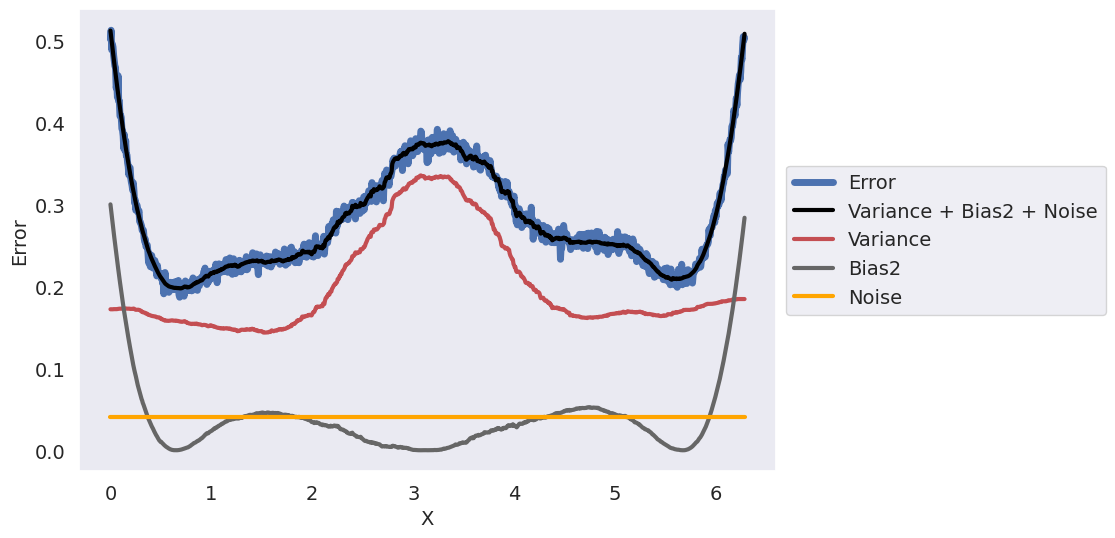

In [14]:
plt.figure(figsize=(9, 6))

plt.plot(X_test, error, label='Error', color='b', linewidth=5)
plt.plot(X_test, composition, label='Variance + Bias2 + Noise', color='0', linewidth=3)
plt.plot(X_test, variance, label='Variance', color='r', linewidth=3)
plt.plot(X_test, bias2, label='Bias2', color='0.4', linewidth=3)
plt.plot(X_test, [noise]*len(X_test), label='Noise', color='orange', linewidth=3)

plt.xticks(size=14)
plt.xlabel("X", size=14)
plt.yticks(size=14)
plt.ylabel("Error", size=14)
plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

## Bonus part on theory
**Attention!** This material is quite difficult! [Here](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/seminars/sem08-bvd.pdf) is a good explanation (in Russian).

For simplicity let us consider the case of one-dimensional linear regression.

**Training algorithm**

For one-dimensional linear regression the relationship between $y$ and $x$ is modeled by the simple linear function $y = kx$. The optimal parameter $k$ is found on training set $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$ via minimization of $\text{MSE}= \sum_{i=1}^\ell (y_i - k x_i)^2$.

As a result we obtain the following algorithm $\mu(X)$ :
    $$
    \mu(X)(x) = k(X ) x, \quad k(X) = \frac{\sum_i x_i y_i}{\sum_i x_i^2}.
    $$

**Generation model**

Assume that $x$ is generated from normal distribution:
$$x \sim p(x) = \mathcal{N}(0, \sigma_1^2).$$

The true label of $x$ is defined by some function with noise:
$$f(x): y = f(x) + \varepsilon,$$
$$\varepsilon \sim p(\varepsilon) = \mathcal{N}(0, \sigma_2^2.)$$

In other words:
$$y \sim p(y|x) = \mathcal{N}(f(x), \sigma_2^2)$$
    
 A sample $X$ consists of $\ell$ independent pairs $(x_i, y_i)$.

**Problem 1.1** Find the noise component for the one-dimensional linear regression.

**Solution**  

$p(y|x)$ is normal, thus, for it we can simply find the expected value:
    $$
    \mathbb{E}[y|x] = f(x).
    $$

  Thus:

$$
    \mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr] =
    \mathbb{E}_{x, \varepsilon}\bigl[(f(x) + \varepsilon - f(x) )^2\bigr] =
    \mathbb{E}_{\varepsilon} \varepsilon^2 = \mathbb{D}\varepsilon + \bigl(\mathbb{E}\varepsilon\bigr)^2 = \sigma_2^2 + 0 = \sigma_2^2.
$$


    

    
**Problem 1.2**

Find the bias component for one-dimensional linear regression $f(x) = ax$.  

**Solution:**

For a start let us find the "average on all the samples" answer of the algorithm on $x$:

$$
    	\mathbb{E}_{X}[\mu(X)(x)] = \mathbb{E}_{X}[k(X)] \, x.
$$
        
We need to find the "average" $k$ on all the samples:

$$ \mathbb{E}_{X}[k(X)] = \int \frac{\sum_i x_i (f(x_i)+\varepsilon_i)}{\sum_i x_i^2} \prod_i \bigl( p(x_i) p(\varepsilon_i) \bigr)  dx_1 \dots dx_\ell \, d\varepsilon_1 \dots d\varepsilon_\ell.
$$
This is an improper integral, which is not always can be calculated analytically.

However, when the dependency is linear we get:
    	$$
    	\mathbb{E}_{X}[k(X)] =  \int \frac{\sum_i x_i (a\,x_i+\varepsilon_i)}{\sum_i x_i^2}  p(\bar x) p(\bar \varepsilon)  d \bar x d \bar \varepsilon =
    	$$
        ...
    	$$
    	=a \int \frac{\sum_i x_i^2}{\sum_i x_i^2}  p(\bar x)  p(\bar \varepsilon)  d \bar x d \bar \varepsilon +
    	\int \frac{\sum_i x_i \varepsilon_i}{\sum_i x_i^2}  p(\bar x)  p(\bar \varepsilon)  d \bar x d \bar \varepsilon.
    	$$
The first integral equals $a$ (as the integral over the entire space of the density function). The second integral equals zero as long as integrand (подынтегральная функция) is odd. Thus, the "average" coefficient equals  $a$.

Let us find the bias component:
  $$
    	\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr] = \mathbb{E}_{x}\bigl[(a x -  a x )^2\bigr] = 0.
  $$

This result is quite intuitive: if we iterate over all possible samples of length $\ell$ and average the value of $k$, then we will be able to find the true value of the coefficient.



**Problem 1.3** Find the variance component for one-dimensional linear regression $f(x) = ax$.  

$$
    	\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr] =
    	\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(
    	a x +  \frac{\sum_i x_i \varepsilon_i}{\sum_i x_i^2} x - ax
    	 )^2\bigr]\bigr]  =\biggl( \mathbb{E}_{x} x^2 \biggr)
    	 \biggl (\mathbb{E}_{X}\biggl(
    	 \frac{\sum_i x_i \varepsilon_i}{\sum_i x_i^2}
    	\biggr )^2\biggr) =
$$
      
$$=\sigma_1^2\mathbb{E}_{X}\biggl (\frac{\sum_i x_i \varepsilon_i}{\sum_i x_i^2} \biggr)^2.
$$

We can simplify the expected value:

$$
    	\mathbb{E}_{X}\biggl(
    	\frac{\sum_i x_i \varepsilon_i}{\sum_i x_i^2}
    	\biggr )^2 = \mathbb{E}_{\bar x} \biggl[ \frac {\sum_{i \ne j} x_i x_j \mathbb{E}_{\bar \varepsilon } [\varepsilon_i \varepsilon_j] +
    		\sum_i x_i^2 \mathbb{E}_{\bar \varepsilon } \varepsilon_i^2 } {(\sum_i x_i^2)^2}
    	 \biggr].
$$

As long as $\varepsilon_i$ and $\varepsilon_j$ are independent, $\mathbb{E}[\varepsilon_i \varepsilon_j] = 0$, and $\mathbb{E}_{\bar \varepsilon } \varepsilon_i^2 = \sigma_2^2$.

Then

$$
    	\mathbb{E}_{X}\biggl(
    	\frac{\sum_i x_i \varepsilon_i}{\sum_i x_i^2}
    	\biggr )^2 = \mathbb{E}_{\bar x} \biggl[ \frac {
    		\sum_i x_i^2 \sigma_2^2} {(\sum_i x_i^2)^2}
    	\biggr] = \sigma_2^2 \mathbb{E}_{\bar x} \biggl[ \frac 1 {\sum_i x_i^2} \biggr],
$$

an variance:
$$
    	\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr] =
    	 \sigma_1^2 \sigma_2^2
    	\mathbb{E}_{\bar x} \biggl[ \frac 1 {\sum_i x_i^2} \biggr].
$$

# 2. Ensembles

### Data  - Titanic data set

Today we are going to work with the Titatic dataset.

In [15]:
#data = pd.read_csv('titanic.csv')
data = pd.read_csv('https://grantmlong.com/data/titanic.csv')
cols_2_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name']
data = data.drop(cols_2_drop, axis=1)
data.loc[:, 'Age'] = data.Age.fillna(-999)
data = data.dropna()
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## Mean label encoding

We have two categorical variables: `Sex` and `Embarked`.

Today we will use the new technique for their encoding: **mean label encoding**.

The idea of **mean label encoding**: for each unique value of the categorical feature, encode it based **on the ratio of occurrence of the positive class in the target variable**.

**Be careful!**

The fact that we are encoding the feature based on target classes may lead to data leakage and overfitting. To solve this, mean encoding is usually used with some type of Regularization.

More information can be found [here](https://towardsdatascience.com/why-you-should-try-mean-encoding-17057262cd0).


**Mean label encoding** for the Sex variable.

In [16]:
mean_sex = data.groupby('Sex')['Survived'].mean()
#the ratio of occurrence of the positive class in the target variable
mean_sex

,Survived
Sex,
female,0.740385
male,0.188908


In [17]:
data['Sex'] = data['Sex'].apply(lambda x: mean_sex[x])

**Mean label encoding** for the Embarked variable.

In [18]:
mean_emb = data[['Embarked', 'Survived']].fillna('No').groupby('Embarked')['Survived'].mean()
data['Embarked'] = data['Embarked'].fillna('No').apply(lambda x: mean_emb[x])
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0.188908,22.0,1,0,7.2500,0.336957
1,1,1,0.740385,38.0,1,0,71.2833,0.553571
2,1,3,0.740385,26.0,0,0,7.9250,0.336957
3,1,1,0.740385,35.0,1,0,53.1000,0.336957
4,0,3,0.188908,35.0,0,0,8.0500,0.336957


In [19]:
X = data.drop('Survived', axis=1)
Y = data['Survived']
#Train test split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=2)
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((711, 7), (178, 7), (711,), (178,))

## Recap: high variance of decision trees

It's said that Decision trees have **high variance**. Small changes in data can lead to radically different trees.

In [20]:
def plot_tree(model, X, fname='temp_tree.png'):
    dot_data = export_graphviz(model, filled=True, rounded=True, feature_names=X.columns, out_file=None)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.write_png(fname)
    img = plt.imread(fname)
    plt.imshow(img)

In [21]:
# Random state affects the order at which predictors are considered. At each split the predictors are randomly permuted
tree1 = DecisionTreeClassifier(random_state=0, max_depth=3)
tree1.fit(train_X, train_Y)
tree1_r2 = r2_score(tree1.predict(test_X), test_Y)
tree1_accuracy = accuracy_score(tree1.predict(test_X), test_Y)
print(f'Accuracy for the first tree: {tree1_accuracy:.4f}')
train_X_2, test_X_2, train_Y_2, test_Y_2 =train_test_split(X, Y, test_size=0.2, random_state=7)

tree2 = DecisionTreeClassifier(random_state=0, max_depth=3)
tree2.fit(train_X_2, train_Y_2)

tree2_accuracy = accuracy_score(tree2.predict(test_X_2), test_Y_2)

print(f'Accuracy for the second tree: {tree2_accuracy:.4f}')

Accuracy for the first tree: 0.7753
Accuracy for the second tree: 0.7978


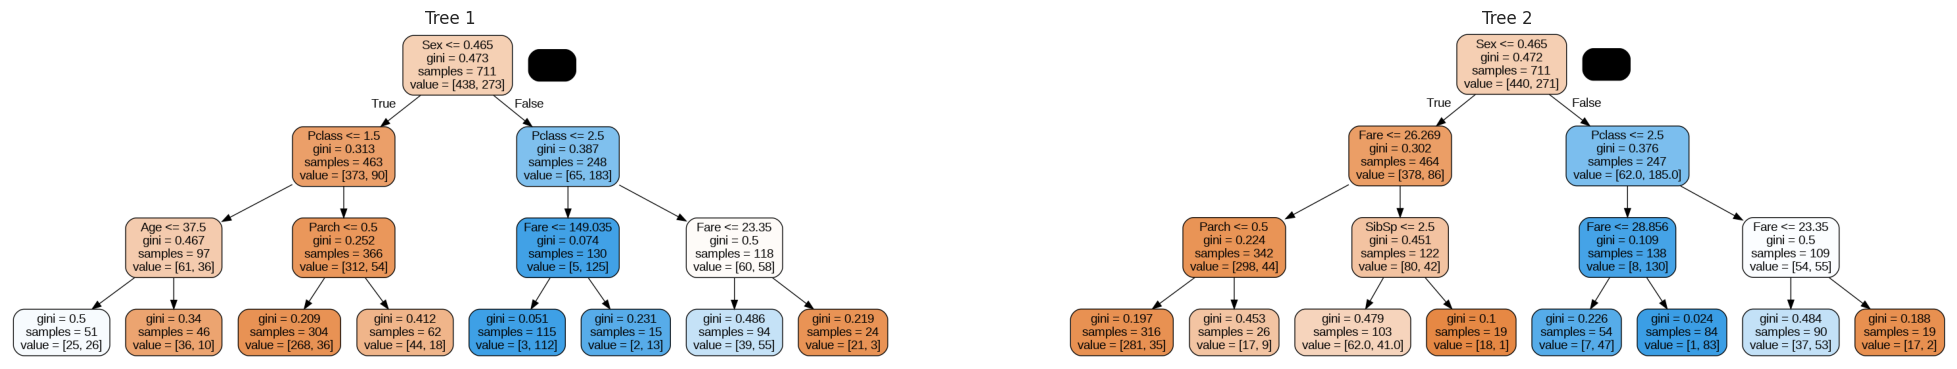

In [22]:
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis('off')
plt.title(f'Tree 1')
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X_2)
plt.axis('off')
plt.title(f'Tree 2')
plt.show()

The dataset is the same and only 20% of data is selected into the test set, but trees are very different and achieve different results.

It only gets worse if we use deeper trees.

## Bootstrap aggregated Decision Trees
Instead of training just one tree, let's do the following:
1. Make $B$ bootstrap (sampling with replacement, remember?) samples from the training set.
2. Fit a decision tree (deep) to each, obtaining $B$ trees $f_1, f_2, \dots, f_B$
3. To predict, average the prediction of all trees: $\hat{y} = 1/B \sum_{i=0}^{B} f_i(x)$


In [23]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)

In [24]:
# BaggingRegressor can be used with any model, not only decision trees

model = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_jobs=-1, n_estimators=100)
model.fit(train_X, train_Y)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                  n_estimators=100, n_jobs=-1)

In [25]:
print(f'Bagged trees accuracy score {accuracy_score(model.predict(test_X), test_Y):.4f}')


Bagged trees accuracy score 0.7978


We can access individual trees.

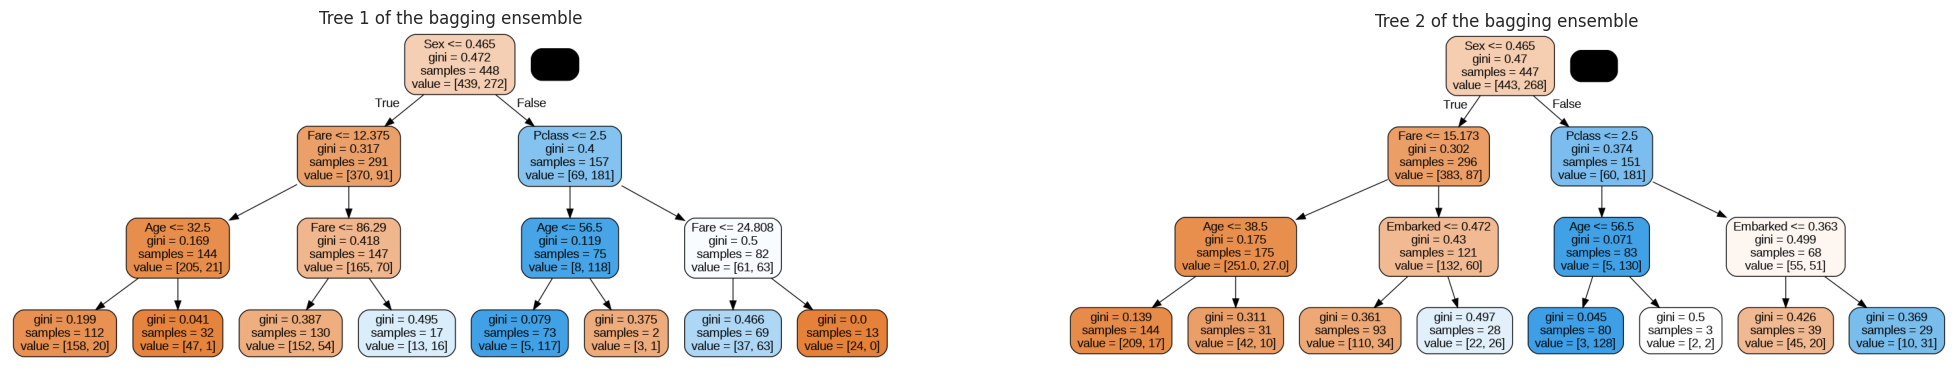

In [26]:
tree1, tree2 = model.estimators_[0], model.estimators_[1]

plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis('off')
plt.title(f'Tree 1 of the bagging ensemble')
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X)
plt.axis('off')
plt.title(f'Tree 2 of the bagging ensemble')
plt.show()

The training process of a Bagged ensemble allows us to estimate the test error **without using cross-validation**!

Each tree is trained on a sample of the training set.

For each observation $x_i$ we can make predictions using the trees for which $x_i$ was not in the training set. Then we can average the predictions and use them to compute the error. This will be a robust test error estimate.

In [27]:
model = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=None), n_jobs=-1, n_estimators=20, oob_score=True)
model.fit(train_X, train_Y)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=20,
                  n_jobs=-1, oob_score=True)

In [28]:
print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Test score estimate using Cross-Validation {cross_val_score(model, train_X, train_Y, scoring="accuracy").mean():.4f}')
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')

Test score estimate using Out-of-bag score 0.8284
Test score estimate using Cross-Validation 0.8059
Actual test score: 0.7753


## Random Forests

Trees in Bagged ensembles tend to be *correlated*. They tend to be very similar. When you aggregate predictions of many similar trees, you don't reduce variance a lot.

How can we make trees less correlated?

**The Random Forest solution**: every time we consider a split, **sample $m$ features** out of the total $p$, such that $m < p$, and **make the best split using these $m$ features**.

In [29]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = 3, oob_score=True)
model.fit(train_X, train_Y)

RandomForestClassifier(max_depth=3, n_jobs=-1, oob_score=True)

In [30]:
print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')

Test score estimate using Out-of-bag score 0.8003
Actual test score: 0.8034


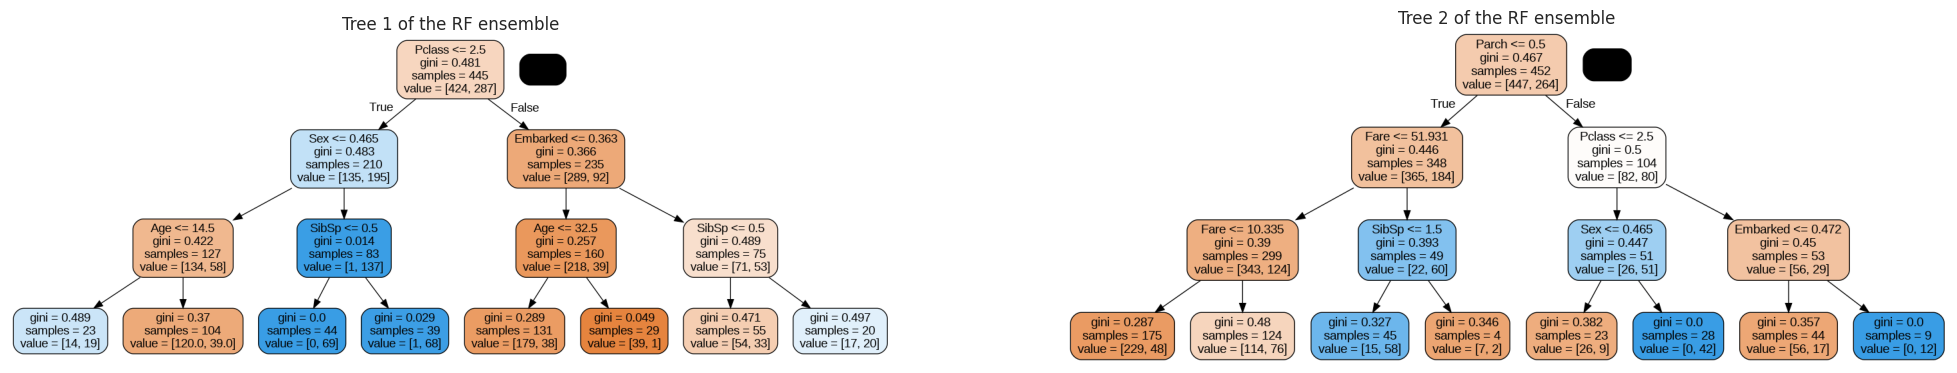

In [31]:
tree1, tree2 = model.estimators_[0], model.estimators_[1]

plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plot_tree(tree1, train_X)
plt.axis('off')
plt.title(f'Tree 1 of the RF ensemble')
plt.subplot(1, 2, 2)
plot_tree(tree2, train_X)
plt.axis('off')
plt.title(f'Tree 2 of the RF ensemble')
plt.show()

In [32]:
# Now lets try realistic max_depth
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth = None, oob_score=True)
model.fit(train_X, train_Y)
print(f'Test score estimate using Out-of-bag score {model.oob_score_:.4f}')
print(f'Actual test score: {accuracy_score(model.predict(test_X), test_Y):.4f}')


Test score estimate using Out-of-bag score 0.8059
Actual test score: 0.7640


## Feature importance

For each tree, we can compute the information gain caused by splitting on some feature. Then if we average this reductions over all trees, we obtain a measure of feature importance.

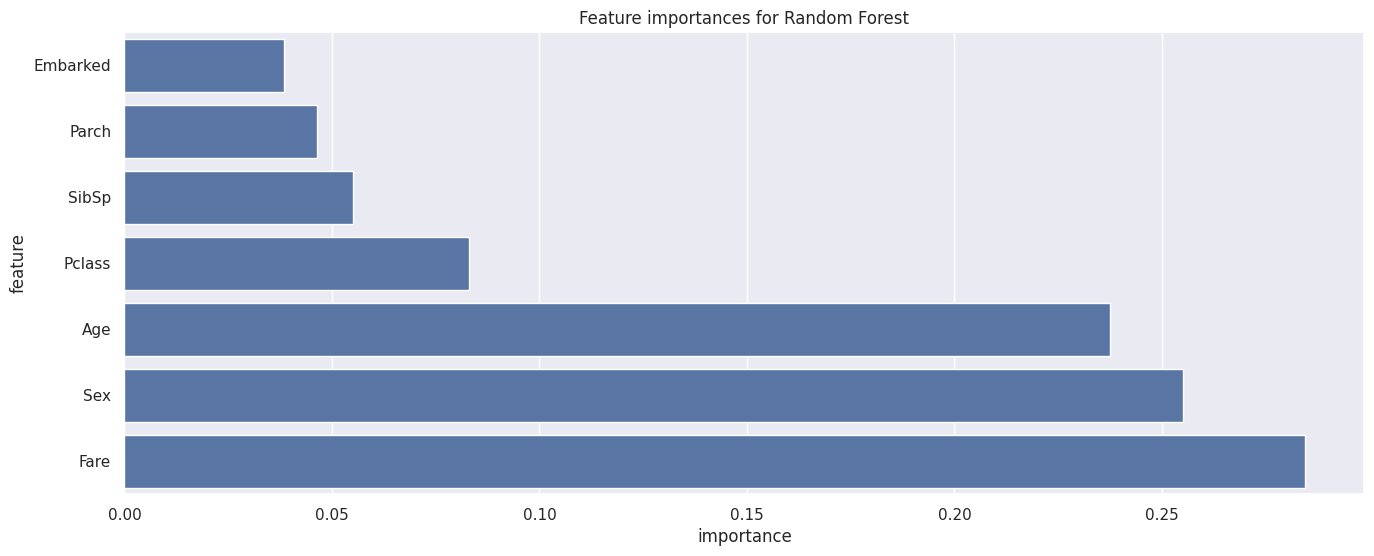

In [33]:
feature_importances = zip(train_X.columns, model.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1])
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

plt.title('Feature importances for Random Forest')
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

## Tuning

The main things to tune for this model:
* `n_estimators` - number of trees,
* `max_samples` - number of samples in bootstrapped training set,
* `max_features` - number of features considered for a split,
* `max_depth` - max depth of trees.
Usually it's advised to keep it unlimited, but it can be beneficial to set a `max_depth` when you want to speed up the algorithm on large data or when the dataset contains a lot of noise.


More info [here](https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/).

In [34]:
parameters = {'n_estimators': [5,10,50, 100, 500], 'max_features' : [None, 3], 'max_depth':[None, 3, 5, 10]}

model = RandomForestClassifier()
clf = GridSearchCV(model, parameters, scoring = 'accuracy', cv = 5)

clf.fit(train_X, train_Y)
pred = clf.predict(test_X)

print('Best parameters: ', clf.best_params_)

Best parameters:  {'max_depth': 10, 'max_features': None, 'n_estimators': 500}


Apart from regression and classification RF can also be used for:
* Clustering
* Anomaly detection
* Dimensionality reduction
* Feature selection

And possibly more!